In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt

In [8]:
muscle = np.empty(0).astype('float32')
n_muscles = 0
tbps = np.empty(0).astype('float32')
tbpc = np.empty((0, 2)).astype('float32')

def add_muscle(path_segment, path_coordinates, tbps, tbpc, muscle):
    path_segment = np.array(path_segment).astype('float32')
    path_coordinates = np.array(path_coordinates).astype('float32')
    n_points = path_segment.size

    # path segments & coordinates should be a (batch_size * n_coordinates  * n_segments * (n_muscles * n_points)
    tbps = np.hstack([tbps, path_segment])
    tbpc = np.vstack([tbpc, path_coordinates])
    m = np.hstack([muscle, np.tile(len(np.unique(muscle))+1, [n_points])])
    return tbps, tbpc, m



tbps, tbpc, muscle = add_muscle(path_segment=[0., 1.], path_coordinates=[[-0.05, 0.], [0.2, 0.]], tbps=tbps, tbpc=tbpc, muscle=muscle)
tbps, tbpc, muscle = add_muscle(path_segment=[1., 2.], path_coordinates=[[0.05, 0.], [0.02, 0.]], tbps=tbps, tbpc=tbpc, muscle=muscle)
tbps, tbpc, muscle = add_muscle(path_segment=[1., 2., 2.], path_coordinates=[[0.1, -0.], [-0.01, -0.02], [0.03, -0.]], tbps=tbps, tbpc=tbpc, muscle=muscle)

print(tbps)
print(tbpc)
print(muscle)
ps = tbps.reshape(1,1,-1)
pc = tf.transpose(tbpc)[tf.newaxis, :, :]
print(ps)
muscle_transitions = np.diff(muscle.reshape(1,1,-1)) == 1.
row_splits = np.concatenate([np.zeros(1), np.diff(muscle).nonzero()[0]+1, np.array([len(muscle)-1])])

[0. 1. 1. 2. 1. 2. 2.]
[[-0.05  0.  ]
 [ 0.2   0.  ]
 [ 0.05  0.  ]
 [ 0.02  0.  ]
 [ 0.1  -0.  ]
 [-0.01 -0.02]
 [ 0.03 -0.  ]]
[1. 1. 2. 2. 3. 3. 3.]
[[[0. 1. 1. 2. 1. 2. 2.]]]


In [3]:
L1 = 1.
sho = np.deg2rad(np.linspace(-45., 150, 21).astype('float32'))
elb = np.deg2rad(np.linspace(0., 150, 18).astype('float32'))
sho2, elb2 = np.meshgrid(sho, elb)
z = tf.zeros_like(sho2.reshape(-1))
joint_state = tf.stack([sho2.reshape(-1), elb2.reshape(-1), z, z], axis=1)

start = time.monotonic()
jpos, jvel = tf.split(joint_state, 2, axis=-1)
sho, elb = tf.split(jpos, 2, axis=-1)
elb += sho

ang = tf.where(ps.flatten() == 0., tf.zeros(1), tf.where(ps.flatten() == 1., -sho, -elb))

rot1 = tf.reshape(tf.concat([tf.cos(ang),  tf.sin(ang)], axis=1), (-1, 2, 7))
rot2 = tf.reshape(tf.concat([-tf.sin(ang), tf.cos(ang)], axis=1), (-1, 2, 7))

dx_da = tf.reduce_sum(-pc * rot2, axis=1, keepdims=True)
dy_da = tf.reduce_sum(pc * rot1, axis=1, keepdims=True)

elb_y = L1 * tf.sin(jpos[:, 0])[:, tf.newaxis, tf.newaxis]
elb_x = L1 * tf.cos(jpos[:, 0])[:, tf.newaxis, tf.newaxis]

dx_da1 = tf.where(ps == 0., tf.zeros(1), dx_da) + tf.where(ps == 2., -elb_y, tf.zeros(1))
dy_da1 = tf.where(ps == 0., tf.zeros(1), dy_da) + tf.where(ps == 2., elb_x, tf.zeros(1))
dx_da2 = tf.where(ps == 2., dx_da, tf.zeros(1))
dy_da2 = tf.where(ps == 2., dy_da, tf.zeros(1))

dxy_da1 = tf.concat([dx_da1, dy_da1], axis=1)
dxy_da2 = tf.concat([dx_da2, dy_da2], axis=1)

dxy_da = tf.concat([dxy_da1[:, :, tf.newaxis, :], dxy_da2[:, :, tf.newaxis, :]], axis=2)
# dxy_dt = tf.stack([dx, dy], axis=1)

sho_vel_3d = jvel[:, 0, tf.newaxis, tf.newaxis]
elb_vel_3d = jvel[:, 0, tf.newaxis, tf.newaxis] + jvel[:, 1, tf.newaxis, tf.newaxis]

dxy_dt = dxy_da1 * sho_vel_3d + dxy_da2 * elb_vel_3d

origin = tf.where(ps == 2, tf.concat([elb_x, elb_y], axis=1), tf.zeros(1))
xy = tf.concat([dy_da, -dx_da], axis=1) + origin

diff_pos = xy[:, :, 1:] - xy[:, :, :-1]
diff_vel = dxy_dt[:, :, 1:] - dxy_dt[:, :, :-1]
diff_ddof = dxy_da[:, :, :, 1:] - dxy_da[:, :, :, :-1]

segment_len = tf.sqrt(tf.reduce_sum(diff_pos ** 2, axis=1, keepdims=True))
segment_vel = tf.reduce_sum(diff_pos * diff_vel / segment_len, axis=1, keepdims=True)
segment_moment = tf.reduce_sum(diff_ddof * diff_pos[:, :, tf.newaxis], axis=1) / segment_len


cleaned_segment_len = tf.where(muscle_transitions, 0., segment_len)
ragged_segment_len = tf.RaggedTensor.from_row_splits(tf.transpose(cleaned_segment_len, [2, 1, 0]), row_splits=row_splits)
muscle_len = tf.reduce_sum(ragged_segment_len, axis=1)

cleaned_segment_vel = tf.where(muscle_transitions, 0., segment_vel)
ragged_segment_vel = tf.RaggedTensor.from_row_splits(tf.transpose(cleaned_segment_vel, [2, 1, 0]), row_splits=row_splits)
muscle_vel = tf.reduce_sum(ragged_segment_vel, axis=1)

cleaned_segment_mom = tf.where(muscle_transitions, 0., segment_moment)
ragged_segment_mom = tf.RaggedTensor.from_row_splits(tf.transpose(cleaned_segment_mom, [2, 1, 0]), row_splits=row_splits)
moment = tf.reduce_sum(ragged_segment_mom, axis=1)

geometry = tf.transpose(tf.concat([muscle_len, muscle_vel, moment], axis=1), [2,1,0])

fin = time.monotonic()
print(fin - start)

0.01600000000325963


In [4]:
print(muscle_len.shape)
print(muscle_vel.shape)
print(moment.shape)
print(geometry.shape)

(3, 1, 378)
(3, 1, 378)
(3, 2, 378)
(378, 4, 3)


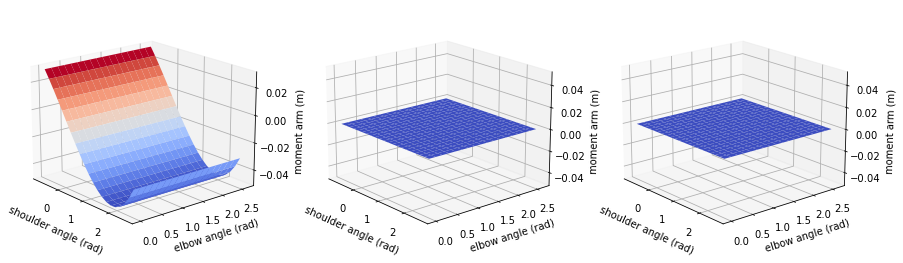

In [5]:
fig = plt.figure(figsize=(15, 6))
#fig.set_tight_layout(True)
for m in range(3):
    ax = fig.add_subplot(1, 3, m+1, projection='3d')
    z = tf.reshape(moment[m, 0, :], (18,21))
    ax.plot_surface(sho2, elb2, z, cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('moment arm (m)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
plt.show()

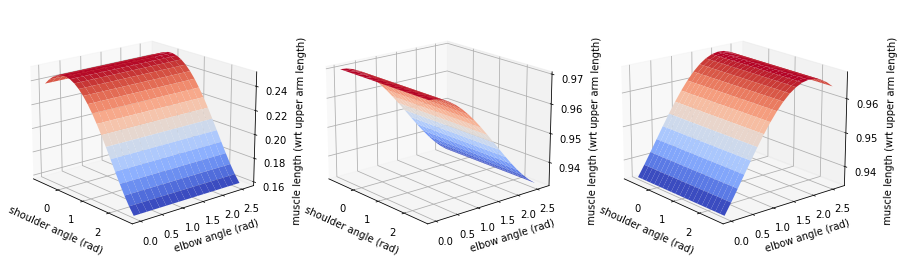

In [6]:
fig = plt.figure(figsize=(15, 6))
for m in range(3):
    ax = fig.add_subplot(1, 3, m+1, projection='3d')
    z = tf.reshape(muscle_len[m, 0, :], (18,21))
    ax.plot_surface(sho2, elb2, z, cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('muscle length (wrt upper arm length)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
plt.show()